In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
df = None
with open('data.pkl','rb') as pickle_file:
   df = pickle.load(pickle_file)
df = pd.DataFrame(df)
# api를 통해 저장된 DB에서 가져온 raw data
df.head()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
0,621515737,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,1460155726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1191489093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,251909718,NaN,NaN,19.0,NaN,14.0,35.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,537506634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 간단한 전처리
df = df.drop(columns=[0])
df.columns = [f"d{i}" for i in range(365, -1, -1)]
df = df.fillna(0)
df = df.astype(int)
df2 = df.copy()
df.head()

,d365,d364,d363,d362,d361,d360,d359,d358,d357,d356,...,d9,d8,d7,d6,d5,d4,d3,d2,d1,d0
0,0,0,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,19,0,14,35,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


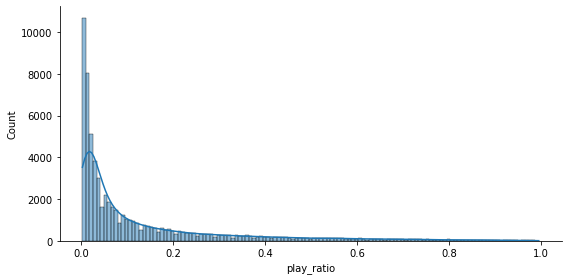

In [4]:
# 모든 유저를 대상으로 하는 예측은 정확도가 낮다 모델에 필요한 유저만 선별한다
# 유저들의 접속률 확인
def toone(x):
   if x != 0:
      return 1
   else:
      return x  
for i in list(df.columns):
    df[i] = df[i].apply(toone)
df = pd.concat([df, df.T.mean()], axis = 1)
col = df.columns
df.columns = list(col[:-1]) + ["play_ratio"]
a = (df["play_ratio"] > 0.05) & (df["play_ratio"] < 0.95)
sns.displot(df["play_ratio"], kde = True,height=4, aspect=2)

In [5]:
# 거의 접속하지 않는 유저나 매일 접속하는 유저는 모델링에 방해가 될 수 있으므로 제거한다
df = df.loc[(df["play_ratio"] > 0.05) & (df["play_ratio"] < 0.95)].reset_index(drop=True)
df2 = df2[a].reset_index(drop=True)
df = df.drop("play_ratio", axis=1)
df.shape

(32056, 366)

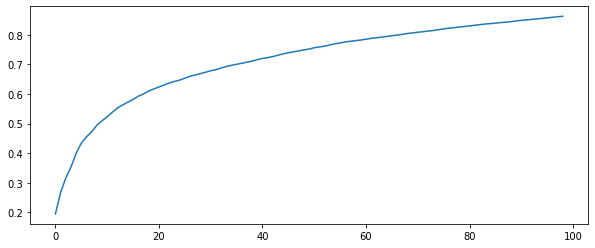

In [6]:
# 라벨링 실시
# N 일 연속으로 미접속한 유저는 이탈 유저일 것이다
# N 이 너무 크면 문제가 이탈을 확인하는데 너무 오래 걸리고, 너무 작으면 실제 이탈 유저가 아닌데 오탐을 할 확률이 높아진다
# 적정한 N을 찾아보자
def count_chum(input_df, intday):
  day = f"d{intday}"
  df = input_df.copy()
  columns = list(df.columns)[::-1]
  columns = columns[columns.index(day):]
  df["result"] = 0
  df['done'] = 0
  for col in columns: 
    df.loc[((df["done"] == 0) & (df[col] == 0)), 'result'] += 1
    df.loc[((df["done"] == 0) & (df[col] == 1)), 'done'] = 1  
  return df
a = count_chum(df,0)['result'].value_counts(normalize=True).sort_index()
aa = []
for i in range(1,100):
    aa.append(sum(a[:i]))
plt.figure(figsize=(10,4))    
plt.plot(aa)

In [7]:
# 데이터 라벨링 N = 20
def prepro(df, intday):
  df_co = count_chum(df, intday)
  df_co3 = count_chum(df, 0)
  df_co3.loc[df_co3['result'] >= intday, 'label'] = 1
  df_co3.loc[df_co3['result'] < intday, 'label'] = 0
  df_co3['label'] = df_co3['label'].apply(lambda x : int(x))
  df_la = pd.concat([df_co, df_co3[["label"]]], axis=1)
  return df_la
y = prepro(df, 20)["label"]
print(y.value_counts(normalize=True))
y = np.array(y)

0    0.61717
1    0.38283
Name: label, dtype: float64


In [8]:
df.shape, df2.shape

((32056, 366), (32056, 366))

In [9]:
# 입력데이터 준비
n = np.array([df.iloc[:,:-20], df2.iloc[:,:-20]])
X = np.zeros((32056,346,2))
for i in range(32056):
    for ii in range(346):
        X[i,ii,0] = n[0,i,ii]
        X[i,ii,1] = n[1,i,ii]

In [10]:
# 훈련데이터 테스트데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y,
train_size = 0.8, 
test_size = 0.2, 
random_state=2,
stratify=y)

In [11]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[:,:,0] = scaler.fit_transform(X_train[:,:,0])
X_test[:,:,0] = scaler.transform(X_test[:,:,0])
scaler = RobustScaler()
X_train[:,:,1] = scaler.fit_transform(X_train[:,:,1])
X_test[:,:,1] = scaler.transform(X_test[:,:,1])

In [12]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(10, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
321/321 [==============================] - 10s 17ms/step - loss: 0.5344 - acc: 0.7685 - val_loss: 0.4989 - val_acc: 0.7754
Epoch 2/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4913 - acc: 0.7724 - val_loss: 0.4587 - val_acc: 0.7888
Epoch 3/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4528 - acc: 0.7923 - val_loss: 0.4276 - val_acc: 0.8019
Epoch 4/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4345 - acc: 0.8009 - val_loss: 0.4219 - val_acc: 0.8033
Epoch 5/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4323 - acc: 0.7999 - val_loss: 0.4198 - val_acc: 0.8039
Epoch 6/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4318 - acc: 0.7987 - val_loss: 0.4186 - val_acc: 0.8027
Epoch 7/10
321/321 [==============================] - 5s 16ms/step - loss: 0.4292 - acc: 0.8015 - val_loss: 0.4168 - val_acc: 0.8029
Epoch 8/10
321/321 [==============================] - 5s 16ms/step -

In [13]:
model.evaluate(X_test, y_test)[1]

201/201 [==============================] - 1s 7ms/step - loss: 0.4267 - acc: 0.7974


0.7974110841751099

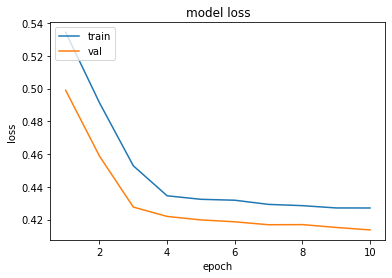

In [14]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1 , 0)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(y_test, y_pred))


from sklearn.metrics import recall_score
print("recall = ", recall_score(y_test, y_pred))

from sklearn.metrics import precision_score
print("precision = ", precision_score(y_test, y_pred))

accuracy =  0.7974111041796631
recall =  0.7344195519348269
precision =  0.7359183673469388


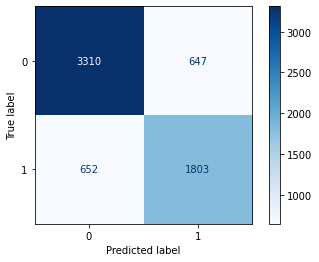

In [16]:
# Confusion Matrix 그리기
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)